<a href="https://colab.research.google.com/github/dpshepherd/PHY452_F2023/blob/main/HW10_off_axis_hologram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unmixing off-axis hologram data

# Exercise goal
The goal of this exercise is to unmix the off-axis digital hologram image that you have been provided.

# Experiment background

You have been provided an off-axis hologram image of a [$10 \mu m$ polystyrene microsphere](https://www.thermofisher.com/order/catalog/product/F8836) embedded in microscopy oil ($n=1.5$) between two glass coverslips ($n=1.515$). The laser source is a [stabilized $785$ nm laser diode](https://www.thorlabs.com/thorproduct.cfm?partnumber=FPL785P). The incident beam k-vector lies along the optical axis and the angle of the off-axis reference beam, with respect to the optical axis, is unknown.

The camera is has a pixel size of $10 \mu m$ and the imaging system has an overall imaging magnfication of $100\times$, yielding an effective pixel size of $0.1 \mu m$. The detection objective is a water immersion model with $NA = 1.0$.

# Theory background

Building on our previous lectures, we know that the electric field, $E(x,y)$ at the plane of interference (the camera sensor) is given by,

$|E(x,y)|^2 = |R(x,y)|^2 + |O(x,y)|^2 + O^*(x,y)R(x,y) + O(x,y)R^*(x,y)$,

with $R$ denoting the reference field and $O$ denoting the object field.

It is useful to think about the real space and reciprocal space configuration just before the camera (see class notes).

Generally, we try to satisfy $\alpha_{max} \sim \frac{\lambda}{2 \Delta x}$, where $\Delta x$ is the effective camera pixel spacing. This ensure that all of the holographic data is contained within the accessible frequency space given the discrete pixel sizes.

It is easiest to unmix the holograms in the Fourier domain,

$\mathcal{F}[|E(x,y)|^2] = \mathcal{F}[|R(x,y)|^2 + |O(x,y)|^2] + \mathcal{F}[O^*(x,y)R(x,y)] + \mathcal{F}[O(x,y)R^*(x,y)]$.

Remember that $R(x,y) = E_Re^{-i\vec{k}_R \cdot \vec{r}}$, which we can plug into the terms we are interested in above to give ($\ast$ denotes convolution),

$\mathcal{F}[O^*(x,y)R(x,y)] = \tilde{O}(\vec{k})^* \ast \mathcal{F}[E_Re^{+i\vec{k}_R \cdot \vec{r}}] $,

and

$\mathcal{F}[O(x,y)R^*(x,y)] = \tilde{O}(\vec{k}) \ast \mathcal{F}[E_Re^{-i\vec{k}_R \cdot \vec{r}}] $.

These contain redundant information, so we will just focus on the second equation. Pratically, it will be fine for unmixing.

From HW #4-5 and our practice with the Fourier shift thm., we know that that $\mathcal{F}[E_Re^{+i\vec{k}_R \cdot \vec{r}}] = \delta (\vec{k}+\vec{k}_R)$, yielding,

$\mathcal{F}[O(x,y)R^*(x,y)] = \tilde{O}(\vec{k}) \ast \delta (\vec{k}+\vec{k}_R)] = \tilde{O}(\vec{k}+\vec{k}_R)$.

The quantity we are interested in is $\tilde{O}(\vec{k})$, which means we need to use the shift thm. and the known reference frequencies to shift back.

$\tilde{O}(k) = \tilde{O}(\vec{k}+\vec{k}_R) \ast \mathcal{F}[E_Re^{-i\vec{k}_R \cdot \vec{r}}]$.

That means from our data, we need to:
1. Find and isolate the area of the digital hologram in reciprocal space that corresponds to $\mathcal{F}[O(x,y)R^*(x,y)]$.
2. Find the reference frequency, $\vec{k}_R$.
3. Use the Fourier shift thm. to shift the digital hologram in reciprocal space.
4. Take the inverse discrete Fourier Transform to obtain the electric fields that correspond to the incident + scattered field from the object.


# Computational approach

### load Python computational and plotting libraries

In [1]:
!pip install ipympl --quiet
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
%matplotlib ipympl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from google.colab import files
from tifffile import imread

### Load the raw off-axis hologram.

In [4]:
dict_files = files.upload()

Saving holos_raw-1.tif to holos_raw-1.tif


Copy the name that Google saved the file into and paste inside the single quotes below.

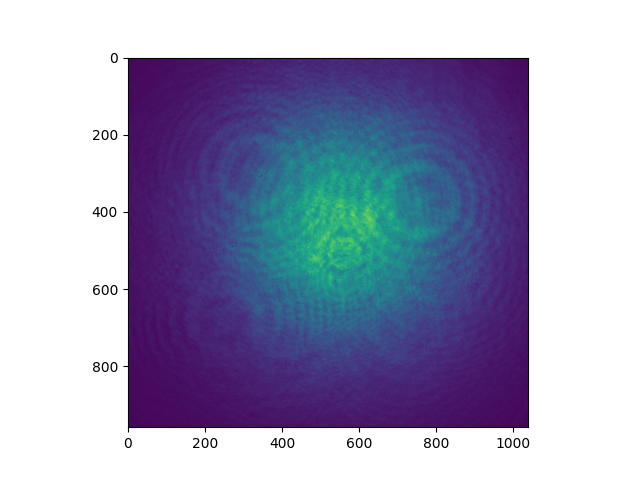

In [5]:
raw_data = imread('holos_raw-1.tif')
raw_data = raw_data[0:-1,0:-1] # make sure array is odd shape, this helps with numerical Fourier transforms

### Create spatial coordinates using pixel spacing with center pixel corresponding to $(x=0,y=0)$.

Remember that python ordering is yx for this array.

In [6]:
camera_pixel_size = 0.1 # microns
x_axis = np.arange(-raw_data.shape[1]/2,raw_data.shape[1]/2)*camera_pixel_size
y_axis = np.arange(-raw_data.shape[0]/2,raw_data.shape[0]/2)*camera_pixel_size
ny, nx = raw_data.shape

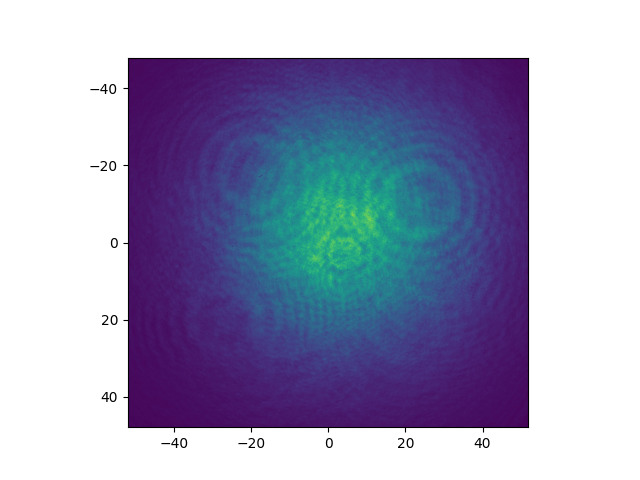

In [7]:
fig, ax = plt.subplots()

# Display the image with specified axes
ax.imshow(raw_data, extent=[x_axis[0], x_axis[-1], y_axis[-1], y_axis[0]]) # for extent, I switched order for y axis because the top left should be the (0,0) value of the array. But extent uses the bottom left by default.

plt.show()

### Calculate discrete Fourier Transform using [numpy.fft](https://numpy.org/doc/stable/reference/routines.fft.html). Ensure center pixel of FFT corresponds to $(k_x=0,k_y=0)$ and the pixel spacing is correct in reciprocal space.

In [8]:
img_ft = np.fft.fftshift(np.fft.fft2(raw_data))

fy_axis =  np.fft.fftshift(np.fft.fftfreq(raw_data.shape[0],d=camera_pixel_size))
fx_axis = np.fft.fftshift(np.fft.fftfreq(raw_data.shape[1], d=camera_pixel_size))

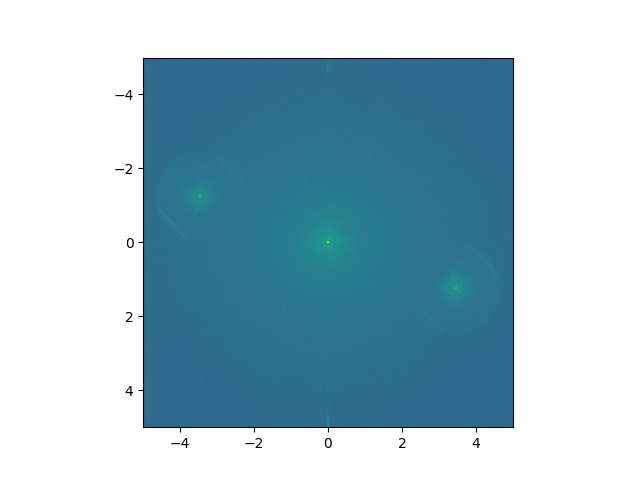

X value -3.78 ; Y value -1.52
X value -3.45 ; Y value -1.24


In [9]:
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print('X value '+str(np.round(ix,2))+' ; Y value ' +str(np.round(iy,2)))

fig, ax = plt.subplots()

ax.imshow(np.abs(img_ft),
           norm=colors.PowerNorm(gamma=0.1),
           extent=[fx_axis[0],fx_axis[-1],fy_axis[-1],fy_axis[0]])

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

### Determine reference beam frequency ($k_R$).

In [10]:
fx_R = -3.45
fy_R = -1.24
# upper left data

### Replot the data in matrix coordinates to figure out where to cut data out

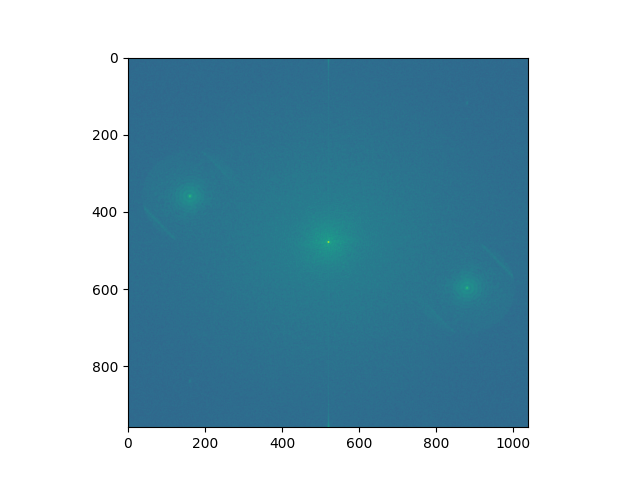

X value 20.82 ; Y value 210.71
X value 36.8 ; Y value 359.96
X value 272.69 ; Y value 360.7
X value 157.35 ; Y value 233.45
X value 158.1 ; Y value 476.04


In [11]:
def onclick(event):
    ix, iy = event.xdata, event.ydata
    print('X value '+str(np.round(ix,2))+' ; Y value ' +str(np.round(iy,2)))

fig, ax = plt.subplots()

ax.imshow(np.abs(img_ft),
           norm=colors.PowerNorm(gamma=0.1))

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

### Define bounding box for off-axis hologram information to use

In [12]:
x_lower_bound = 20
x_upper_bound = 280
y_lower_bound = 210
y_upper_bound = 476

### Clear data outside of desired off-axis component (either $\mathcal{F}[O^*R]$ or $\mathcal{F}[OR^*]$).

Cut out the off-axis hologram, place it in the middle of a new array, and pad that array to match the size of our original hologram.

In [13]:
# ensure crop is odd sized
crop_width = x_upper_bound - x_lower_bound
crop_height = y_upper_bound - y_lower_bound

if crop_width % 2 == 0:
    x_upper_bound += 1
    crop_width += 1

if crop_height % 2 == 0:
    y_upper_bound += 1
    crop_height += 1

# Extract the cropped area
img_ft_cropped = img_ft[y_lower_bound:y_upper_bound, x_lower_bound:x_upper_bound]

# Calculate padding sizes
pad_left = (nx - crop_width) // 2
pad_right = nx - crop_width - pad_left
pad_top = (ny - crop_height) // 2
pad_bottom = ny - crop_height - pad_top

# Apply padding to match the original array size
img_ft_cropped = np.pad(img_ft_cropped, ((pad_top, pad_bottom), (pad_left, pad_right)))

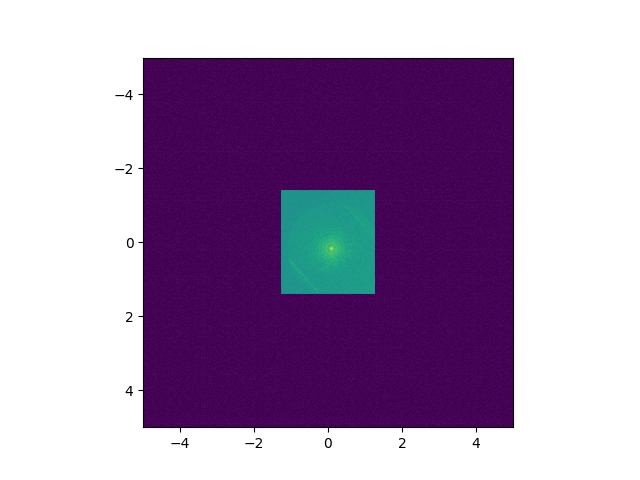

In [14]:
fig, ax = plt.subplots()

ax.imshow(np.abs(img_ft_cropped),
           norm=colors.PowerNorm(gamma=0.1),
          extent=[fx_axis[0],fx_axis[-1],fy_axis[-1],fy_axis[0]])

plt.show()

### Construct the reference beam matrix to use in the Fourier shift thm.

In [15]:
ny, nx = img_ft.shape

ref_matrix = np.zeros_like(img_ft_cropped)

x_idx = 0
y_idx = 0
for fy_value in fy_axis:
  for fx_value in fx_axis:
    ref_matrix[y_idx,x_idx] = np.exp(-1j*2*np.pi*(fx_value*fx_R+fy_value*fy_R))
    x_idx = x_idx + 1
  y_idx = y_idx + 1
  x_idx = 0

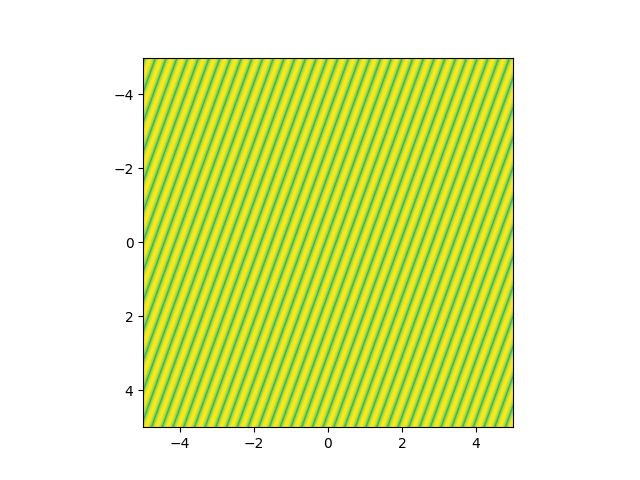

In [16]:
fig, ax = plt.subplots()

ax.imshow(ref_matrix.imag,
           norm=colors.PowerNorm(gamma=0.1),
          extent=[fx_axis[0],fx_axis[-1],fy_axis[-1],fy_axis[0]])

plt.show()

### Use Fourier shift thm. to recover $\tilde{O}(k_x,k_y)$.

Given img_ft(f), return the translated function

img_ft_shifted(f) = img_ft(f + shift_frq)

using the FFT shift relationship,

img_ft(f + shift_frq) = F[ exp(-2*pi*i * shift_frq * r) * img(r) ]


In [17]:
img_ft_shifted = np.fft.fftshift(np.fft.fft2(ref_matrix * np.fft.ifft2(np.fft.ifftshift(img_ft_cropped))))

### Finally, use the inverse FFT to recover $O(x,y)$.

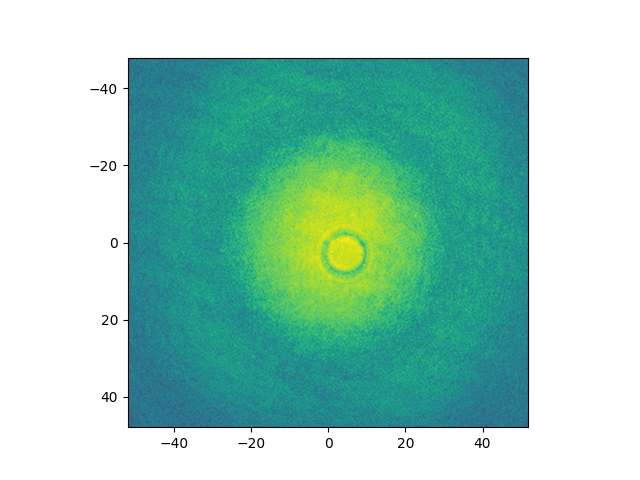

In [26]:
img_recovered = np.fft.ifft2(np.fft.ifftshift(img_ft_shifted))

fig, ax = plt.subplots()

ax.imshow((img_recovered*np.conjugate(img_recovered)).real,
           norm=colors.PowerNorm(gamma=0.1),
          extent=[x_axis[0],x_axis[-1],y_axis[-1],y_axis[0]])

plt.show()

### Does $O(x,y)$ match your expectations? What more can you learn about the object based on what we have done in class?